# 模型选择、欠拟合和过拟合
通过多项式拟合

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

# 使用以下3阶多项式来生成训练和测试数据的标签
# $y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{    where } \epsilon \sim \mathcal{N}(0, 0.1^2).$

In [2]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集的大小
true_w = np.zeros(max_degree)   # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train+n_test,1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i+1)

# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

# 存储在poly_features中的单项式由gamma函数重新缩放， 其中 $\Gamma(n)=(n-1)!$ 。 从生成的数据集中查看一下前2个样本， 第一个值是与偏置相对应的常量特征。

In [3]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=torch.float32) for x in [true_w,features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[0.3035],
         [0.3820]]),
 tensor([[1.0000e+00, 3.0348e-01, 4.6051e-02, 4.6586e-03, 3.5346e-04, 2.1454e-05,
          1.0851e-06, 4.7046e-08, 1.7847e-09, 6.0182e-11, 1.8264e-12, 5.0391e-14,
          1.2744e-15, 2.9751e-17, 6.4492e-19, 1.3048e-20, 2.4750e-22, 4.4183e-24,
          7.4494e-26, 1.1899e-27],
         [1.0000e+00, 3.8197e-01, 7.2950e-02, 9.2883e-03, 8.8696e-04, 6.7758e-05,
          4.3136e-06, 2.3538e-07, 1.1239e-08, 4.7698e-10, 1.8219e-11, 6.3265e-13,
          2.0138e-14, 5.9169e-16, 1.6143e-17, 4.1109e-19, 9.8139e-21, 2.2051e-22,
          4.6793e-24, 9.4071e-26]]),
 tensor([5.1873, 5.2937]))

# 实现一个函数来评估模型再给定数据集上的损失

In [4]:
def evaluate_loss(net, data_iter, loss):
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

# 定义训练函数

In [5]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))  # 不设置偏置，因为我们已经在多项式中实现了它
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)), batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)), batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log', xlim=[1, num_epochs], ylim=[1e-3, 1e2], legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch+1)%20 == 0:
            animator.add(epoch+1, (evaluate_loss(net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

# 三阶多项式函数拟合(正常)
我们将首先使用三阶多项式函数，它与数据生成函数的阶数相同。 结果表明，该模型能有效降低训练损失和测试损失。 学习到的模型参数也接近真实值$w = [5, 1.2, -3.4, 5.6]$。

weight: [[ 4.999148   1.2282134 -3.3942022  5.536457 ]]


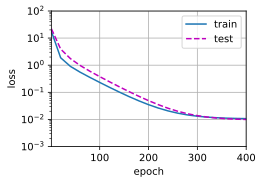

In [6]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4], labels[:n_train], labels[n_train:])

# 线性函数拟合(欠拟合)
让我们再看看线性函数拟合，减少该模型的训练损失相对困难。 在最后一个迭代周期完成后，训练损失仍然很高。 当用来拟合非线性模式（如这里的三阶多项式函数）时，线性模型容易欠拟合。

weight: [[3.9806998 2.9604516]]


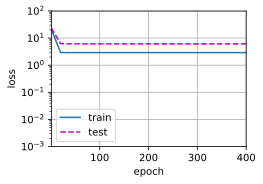

In [7]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2], labels[:n_train], labels[n_train:])

# 高阶多项式函数拟合(过拟合)
现在，让我们尝试使用一个阶数过高的多项式来训练模型。 在这种情况下，没有足够的数据用于学到高阶系数应该具有接近于零的值。 因此，这个过于复杂的模型会轻易受到训练数据中噪声的影响。 虽然训练损失可以有效地降低，但测试损失仍然很高。 结果表明，复杂模型对数据造成了过拟合。

weight: [[ 5.00074100e+00  1.27905381e+00 -3.34602737e+00  5.15816116e+00
  -3.85556608e-01  1.38203120e+00  3.01617563e-01  7.56335929e-02
   2.32203066e-01  1.98130161e-01 -2.06818506e-01 -2.20191300e-01
  -4.17492585e-03 -2.06079647e-01 -1.34680539e-01  1.06719814e-01
  -6.67104125e-02 -9.79215875e-02 -1.39515987e-02  2.15456605e-01]]


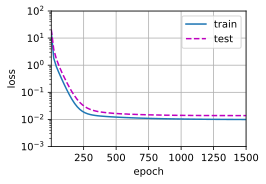

In [8]:
train(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:], num_epochs=1500)